# XStoryCloze evaluation

In [1]:
import pandas as pd

def get_dfs(model_names):
    acc_df = pd.DataFrame()
    ppl_cor_df = pd.DataFrame()
    ppl_inc_df = pd.DataFrame()

    for model_name in model_names:
        name = model_name.split("/")[-1]
        metrics_df = pd.read_csv(f"../results/xstory_cloze_{name}_metrics.tsv", delimiter="\t")
        acc_df["lang"] = metrics_df["lang"]
        ppl_cor_df["lang"] = metrics_df["lang"]
        ppl_inc_df["lang"] = metrics_df["lang"]
        acc_df[name] = metrics_df["acc"]
        ppl_cor_df[name] = metrics_df["ppl_cor"]
        ppl_inc_df[name] = metrics_df["ppl_inc"]

    return acc_df, ppl_cor_df, ppl_inc_df

import matplotlib.pyplot as plt

def plot_df(df, title):
    df.plot.bar()
    plt.title(title)
    plt.xticks(list(range(12)), df["lang"], rotation='vertical')
    plt.show()

## mGPT

In [2]:
metrics_df = pd.read_csv(f"../results/xstory_cloze_mGPT_metrics.tsv", delimiter="\t")

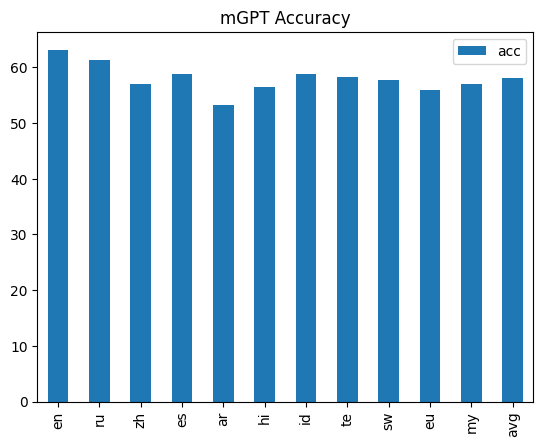

In [3]:
plot_df(metrics_df[["lang", "acc"]], "mGPT Accuracy")

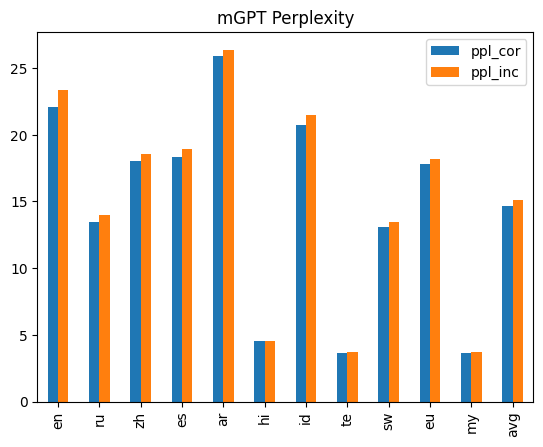

In [4]:
plot_df(metrics_df[["lang", "ppl_cor", "ppl_inc"]], "mGPT Perplexity")

## XGLM

In [5]:
xglm_model_names=[
    "facebook/xglm-564M",
    "facebook/xglm-1.7B",
    "facebook/xglm-2.9B",
    "facebook/xglm-4.5B",
    "facebook/xglm-7.5B",
]
xglm_model_sizes = [0.6, 1.7, 2.9, 4.5, 7.5]
xglm_names = [name.split("/")[-1] for name in xglm_model_names]
acc_df, ppl_cor_df, ppl_inc_df = get_dfs(xglm_model_names)

In [6]:
display(acc_df)
display(ppl_cor_df)
display(ppl_inc_df)

,lang,xglm-564M,xglm-1.7B,xglm-2.9B,xglm-4.5B,xglm-7.5B
0,en,61.3,66.6,69.6,72.1,73.7
1,ru,59.5,62.8,67.2,66.8,69.0
2,zh,56.3,60.2,64.1,64.4,65.9
3,es,56.5,60.6,64.6,66.4,66.7
4,ar,53.9,55.6,57.7,57.7,58.5
5,hi,54.2,56.8,59.4,57.1,59.5
6,id,56.8,61.5,65.5,65.6,68.0
7,te,56.9,58.4,59.4,58.7,60.6
8,sw,56.4,60.8,60.8,60.1,63.3
9,eu,55.1,57.5,58.4,55.3,61.7


,lang,xglm-564M,xglm-1.7B,xglm-2.9B,xglm-4.5B,xglm-7.5B
0,en,22.79,18.21,16.48,15.51,15.25
1,ru,22.82,17.39,15.86,14.83,14.56
2,zh,35.40,27.15,24.08,22.48,21.87
3,es,26.19,19.74,17.58,16.52,15.87
4,ar,48.08,34.52,28.31,29.55,25.42
5,hi,24.64,19.38,17.33,22.04,16.25
6,id,46.69,34.85,30.64,31.25,27.98
7,te,30.85,26.20,21.83,27.97,19.91
8,sw,51.94,36.14,30.84,51.51,27.13
9,eu,37.03,24.64,21.55,116.39,20.23


,lang,xglm-564M,xglm-1.7B,xglm-2.9B,xglm-4.5B,xglm-7.5B
0,en,23.98,19.52,17.92,16.99,16.74
1,ru,23.66,18.27,16.87,15.79,15.59
2,zh,36.31,28.17,25.29,23.71,23.17
3,es,27.03,20.67,18.62,17.56,16.96
4,ar,48.80,35.38,29.22,30.51,26.36
5,hi,25.02,19.83,17.89,22.73,16.83
6,id,48.46,36.85,32.87,33.58,30.38
7,te,31.76,27.14,22.73,29.02,20.78
8,sw,53.58,37.69,32.44,53.61,28.67
9,eu,38.09,25.45,22.40,119.46,21.18


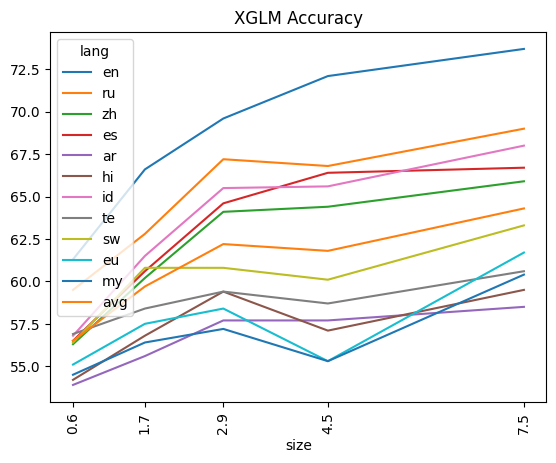

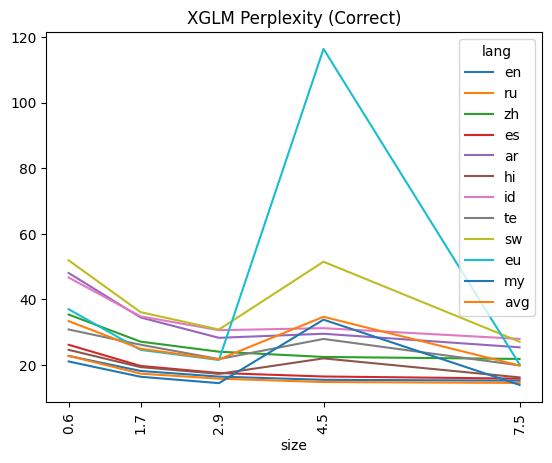

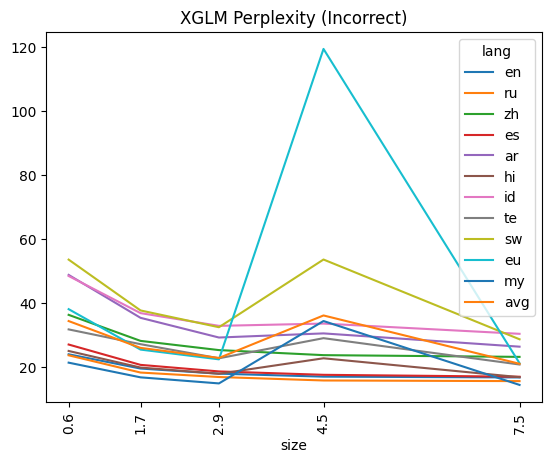

In [7]:
# create a function to create the previous plot for any model
def plot_size_df(df, model_sizes, model_names, title):
    dft = df.set_index("lang").T
    dft["size"] = model_sizes
    dft.plot(x="size")
    plt.title(title)
    plt.xticks(model_sizes, model_sizes, rotation='vertical');

plot_size_df(acc_df, xglm_model_sizes, xglm_names, "XGLM Accuracy")
plot_size_df(ppl_cor_df, xglm_model_sizes, xglm_names, "XGLM Perplexity (Correct)")
plot_size_df(ppl_inc_df, xglm_model_sizes, xglm_names, "XGLM Perplexity (Incorrect)")

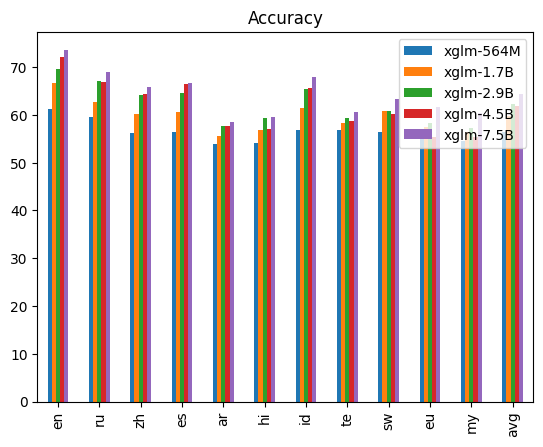

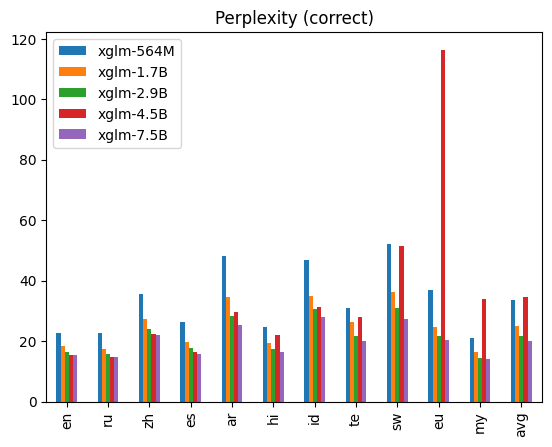

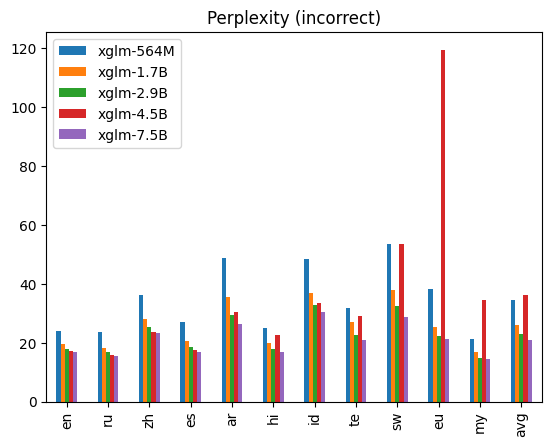

In [8]:
plot_df(acc_df, "Accuracy")
plot_df(ppl_cor_df, "Perplexity (correct)")
plot_df(ppl_inc_df, "Perplexity (incorrect)")

## BLOOM

In [9]:
bloom_model_names=[
    "bigscience/bloom-560m",
    "bigscience/bloom-1b1",
    "bigscience/bloom-1b7",
    "bigscience/bloom-3b",
    "bigscience/bloom-7b1",
]
bloom_names = [name.split("/")[-1] for name in bloom_model_names]
bloom_model_sizes = [0.6, 1.1, 1.7, 3.0, 7.1]
acc_df, ppl_cor_df, ppl_inc_df = get_dfs(bloom_model_names)

In [10]:
display(acc_df)
display(ppl_cor_df)
display(ppl_inc_df)

,lang,bloom-560m,bloom-1b1,bloom-1b7,bloom-3b,bloom-7b1
0,en,64.1,67.4,70.0,72.1,74.9
1,ru,55.3,54.3,56.7,57.7,59.2
2,zh,58.8,63.3,65.0,67.3,69.4
3,es,58.7,61.3,64.3,67.0,70.1
4,ar,52.7,56.5,56.0,59.6,62.5
5,hi,54.3,56.7,57.8,58.6,62.7
6,id,56.9,61.8,62.9,66.8,69.4
7,te,55.2,55.3,56.0,58.5,57.5
8,sw,52.7,53.7,57.7,58.0,59.2
9,eu,53.8,53.8,55.7,57.2,59.0


,lang,bloom-560m,bloom-1b1,bloom-1b7,bloom-3b,bloom-7b1
0,en,27.02,22.54,20.10,17.80,15.85
1,ru,28.78,23.39,18.00,15.34,12.32
2,zh,55.17,45.48,39.99,36.09,32.22
3,es,25.30,21.30,18.92,17.04,15.54
4,ar,103.19,52.33,44.87,38.73,33.41
5,hi,40.11,33.15,28.04,25.59,22.50
6,id,4961.86,56.01,47.57,39.90,35.37
7,te,293.01,126.69,69.79,68.77,54.97
8,sw,744.97,411.55,202.55,151.57,100.76
9,eu,128.30,96.47,66.39,55.15,44.85


,lang,bloom-560m,bloom-1b1,bloom-1b7,bloom-3b,bloom-7b1
0,en,28.81,24.26,21.87,19.55,17.65
1,ru,29.49,23.90,18.44,15.74,12.72
2,zh,58.37,48.63,43.06,39.22,35.48
3,es,26.37,22.36,20.11,18.29,16.86
4,ar,126.52,54.21,46.74,40.70,35.56
5,hi,41.07,34.22,29.04,26.71,23.62
6,id,5641.60,59.37,50.95,43.09,38.81
7,te,361.22,131.40,72.24,71.49,57.27
8,sw,760.27,425.09,212.35,159.80,107.09
9,eu,131.41,99.31,68.93,57.18,47.04


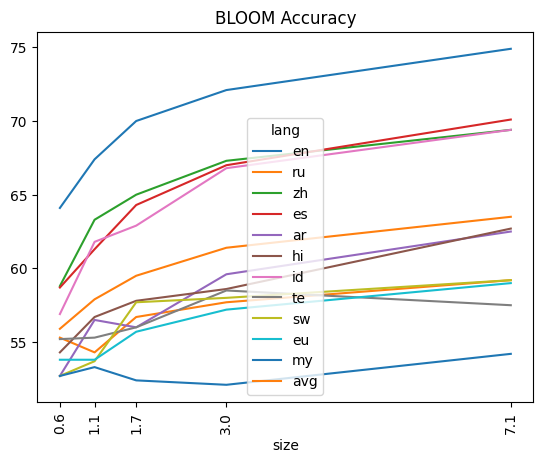

In [11]:
plot_size_df(acc_df, bloom_model_sizes, bloom_names, "BLOOM Accuracy")

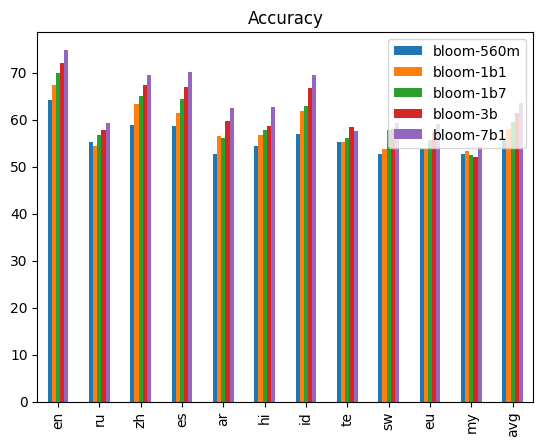

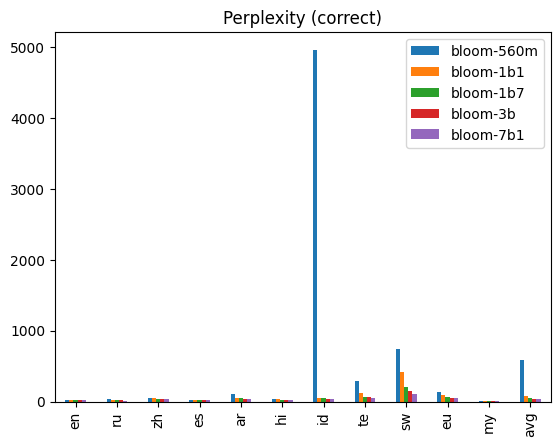

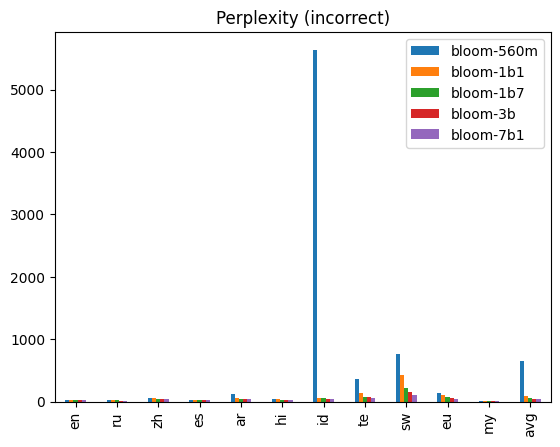

In [12]:
plot_df(acc_df, "Accuracy")
plot_df(ppl_cor_df, "Perplexity (correct)")
plot_df(ppl_inc_df, "Perplexity (incorrect)")

## BLOOMZ

In [18]:
bloomz_model_names=[
    "bigscience/bloomz-560m",
    "bigscience/bloomz-1b1",
    "bigscience/bloomz-1b7",
    "bigscience/bloomz-3b",
    "bigscience/bloomz-7b1",
    "bigscience/bloomz-7b1-mt",
    "bigscience/bloomz-7b1-p3",
]
bloomz_names = [name.split("/")[-1] for name in bloomz_model_names]
bloomz_model_sizes = [0.6, 1.1, 1.7, 3.0, 7.1, 7.1, 7.1]
acc_df, ppl_cor_df, ppl_inc_df = get_dfs(bloomz_model_names)

In [14]:
display(acc_df)
display(ppl_cor_df)
display(ppl_inc_df)

,lang,bloomz-560m,bloomz-1b1,bloomz-1b7,bloomz-3b,bloomz-7b1,bloomz-7b1-mt,bloomz-7b1-p3
0,en,66.0,68.8,72.4,74.4,78.0,78.4,78.1
1,ru,54.9,53.5,55.1,56.2,56.8,57.0,59.1
2,zh,62.3,64.3,63.1,62.9,66.8,67.6,73.2
3,es,60.0,62.3,60.4,58.3,68.0,67.5,69.2
4,ar,55.2,58.1,56.3,56.3,60.8,62.1,66.5
5,hi,54.6,57.4,55.1,55.3,59.6,57.8,65.8
6,id,50.6,62.9,57.9,58.2,61.5,61.2,67.5
7,te,52.5,55.0,52.0,52.8,55.3,54.5,59.2
8,sw,53.4,53.5,52.4,53.8,54.9,56.2,59.2
9,eu,47.1,52.0,47.2,45.9,52.9,51.1,59.1


,lang,bloomz-560m,bloomz-1b1,bloomz-1b7,bloomz-3b,bloomz-7b1,bloomz-7b1-mt,bloomz-7b1-p3
0,en,2.663000e+01,21.49,19.91,18.08,16.20,16.05,17.41
1,ru,3.940300e+02,30.63,354.99,83.25,38.55,37.22,15.15
2,zh,6.165000e+01,42.79,1389.12,10577.60,1213.95,955.81,80.32
3,es,3.277000e+01,21.27,112.01,204.44,52.45,87.30,24.21
4,ar,1.353428e+20,51.70,9108.57,11274.28,869.81,793.57,66.95
5,hi,inf,35.76,59467.21,40187.16,4094.74,10718.34,51.63
6,id,inf,75.04,8942.82,6850.11,7514.54,12328.59,78.17
7,te,4.527220e+04,110.11,75023.46,78807.06,18815.54,31012.91,85.13
8,sw,2.747939e+05,440.49,2814.52,5520.99,3443.45,4015.72,200.47
9,eu,1.444126e+04,347.18,55461.08,50308.44,10414.33,14618.84,97.82


,lang,bloomz-560m,bloomz-1b1,bloomz-1b7,bloomz-3b,bloomz-7b1,bloomz-7b1-mt,bloomz-7b1-p3
0,en,2.855000e+01,23.35,21.90,20.12,18.38,18.22,19.99
1,ru,4.069600e+02,31.23,366.72,85.47,39.96,38.61,15.67
2,zh,6.615000e+01,46.27,1572.97,11893.31,1309.30,1029.11,91.81
3,es,3.422000e+01,22.48,117.97,216.23,56.80,93.92,26.76
4,ar,1.756568e+24,54.09,9366.78,11302.37,836.65,758.67,72.75
5,hi,inf,37.11,63052.43,42266.12,4548.97,11204.17,55.20
6,id,inf,79.60,9406.99,7212.92,8187.43,13391.42,87.36
7,te,3.419842e+05,113.52,77094.08,81000.70,19245.03,31911.02,89.61
8,sw,2.635792e+05,452.33,2891.41,5676.87,3588.96,4212.77,214.06
9,eu,1.393044e+04,353.97,55513.47,49665.22,10423.75,14611.92,104.56


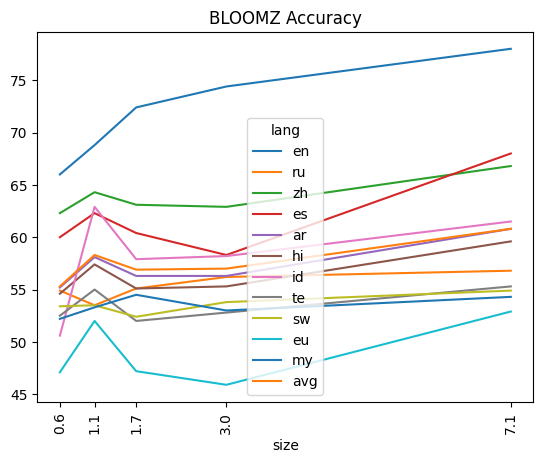

In [23]:
plot_size_df(acc_df[["lang", "bloomz-560m", "bloomz-1b1", "bloomz-1b7", "bloomz-3b", "bloomz-7b1"]], bloomz_model_sizes[:-2], bloomz_names[:-2], "BLOOMZ Accuracy")

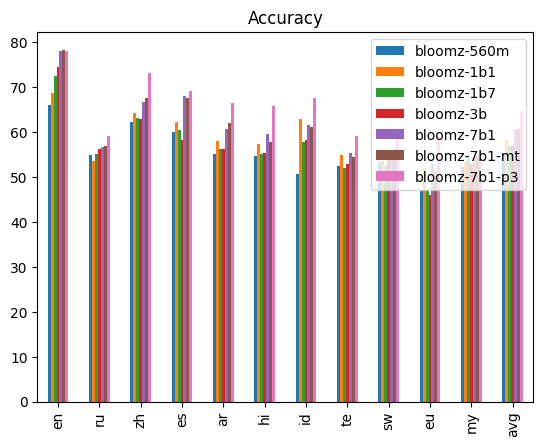

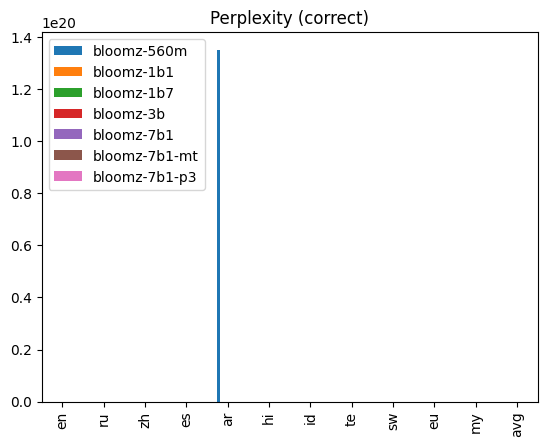

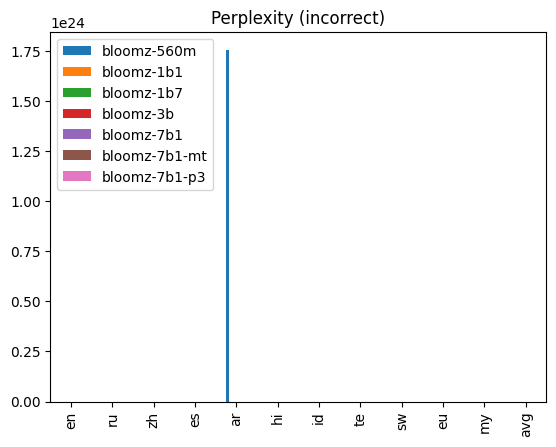

In [16]:
plot_df(acc_df, "Accuracy")
plot_df(ppl_cor_df, "Perplexity (correct)")
plot_df(ppl_inc_df, "Perplexity (incorrect)")